In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

from copy import deepcopy as copy
from torch.distributions.normal import Normal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

# Forward

In [3]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [4]:
n_steps = 100
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [5]:
def extract(input, t, x):
    '''
    Extract value 'alpha_bar_sqrt', 'one_minus_alpha_bar_sqrt' at any given 't' step.
    '''
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

# reverse

In [6]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

In [7]:
model = ConditionalModel(n_steps)
model

ConditionalModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=2, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin3): Linear(in_features=128, out_features=4, bias=True)
)

# DDPM

In [8]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)
    
    
def p_sample(model, x, t):
    
    t = torch.tensor([t]).to(device)
    
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x)).to(device)
    
    # Model output
    eps_theta = model(x, t).to(device)
    
    # Final values
    mean = (1 / extract(alphas.to(device), t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x).to(device)
    
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt().to(device)
    sample = mean + sigma_t * z
    
    return (sample)


def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x.to(device), i)
        x_seq.append(cur_x)
    return x_seq

In [9]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    
    # Select a random step for each example of a batch(128)
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long().to(device)
    
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(device)
    
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(device)
    e = torch.randn_like(x_0).to(device)
    
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)  # model := e_{epsilon}(x, t)
    
    return (e - output).square().mean()

In [10]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = torch.tensor(mu).to(device)
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone().to(device)

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

  0%|          | 0/1000 [00:00<?, ?it/s]

1.2196933031082153
1.1376149654388428
0.728223443031311
0.7466349005699158
0.6605695486068726
1.0765513181686401
0.9320947527885437
0.9620076417922974
0.7130903005599976
0.5876027941703796


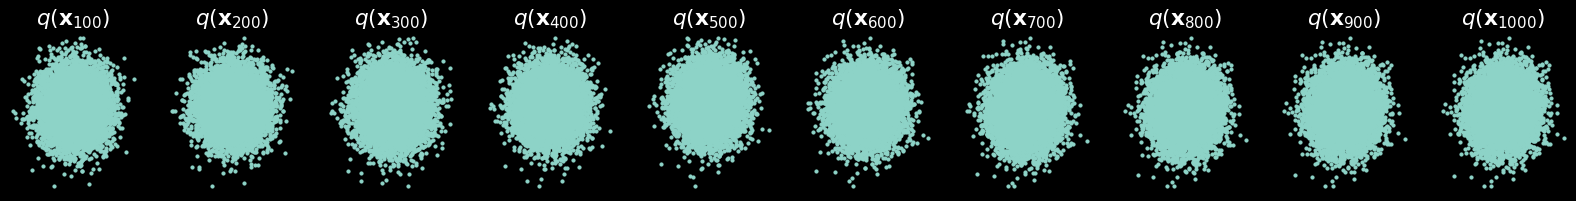

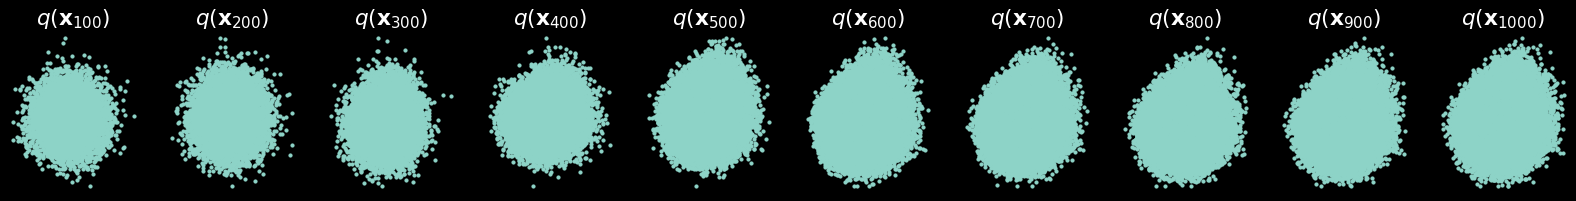

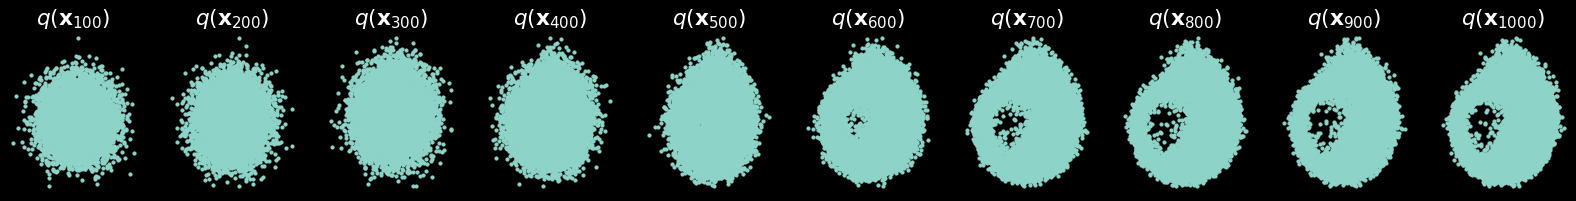

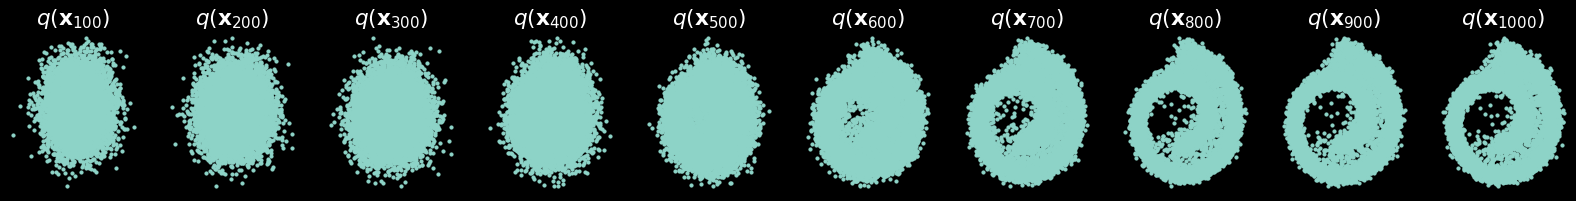

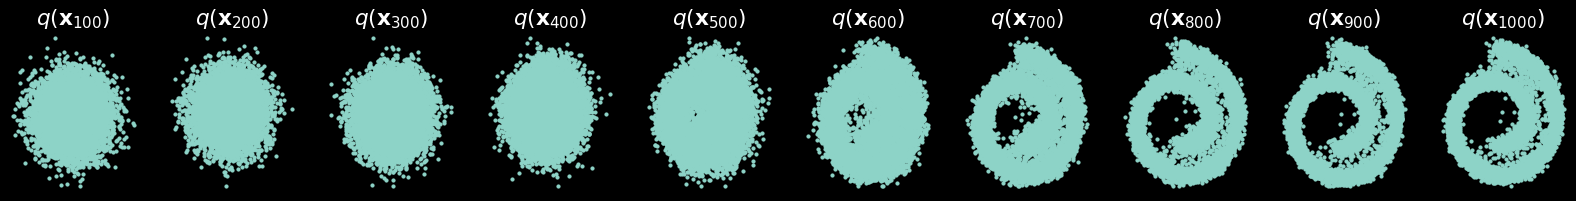

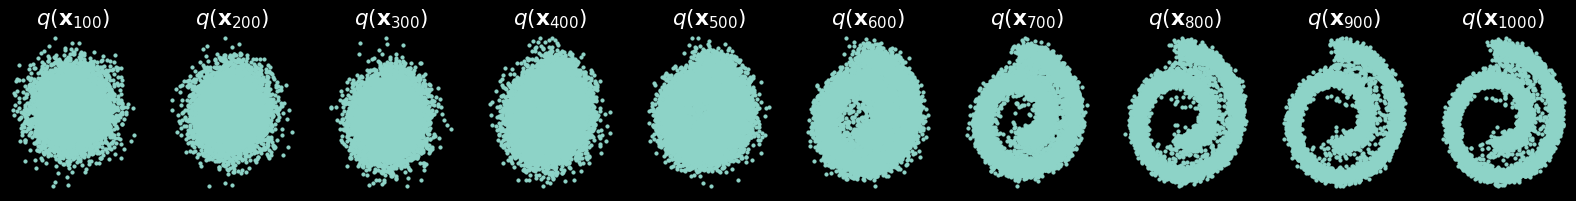

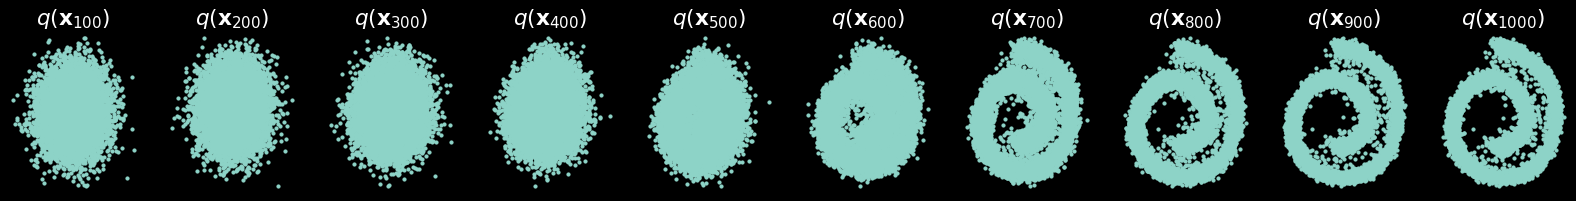

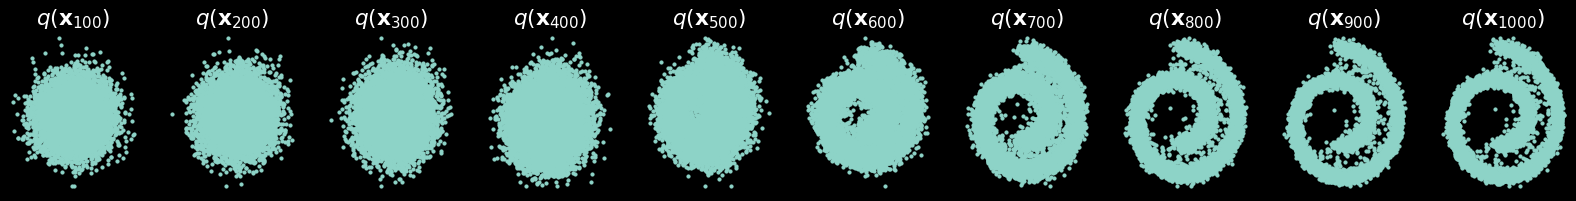

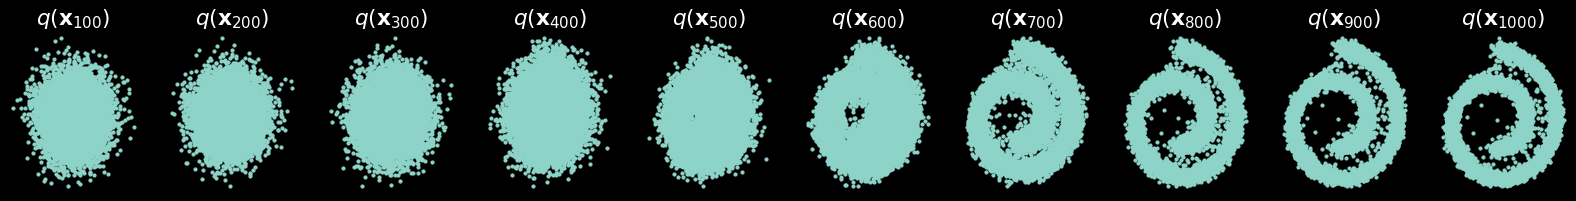

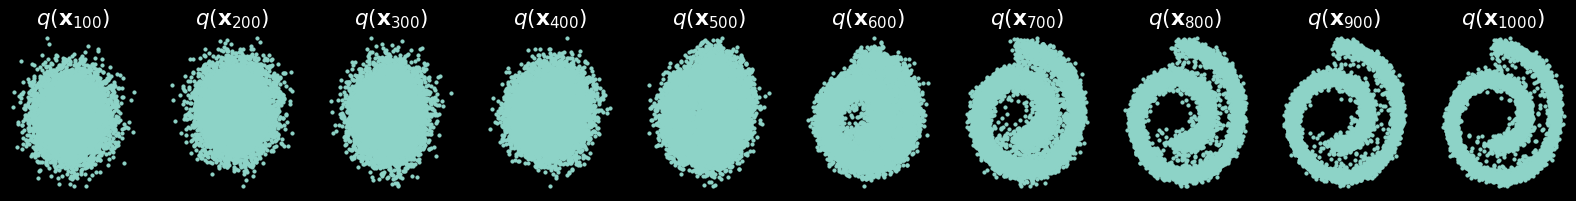

In [11]:
data = sample_batch(10**4).T

model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()

# Create EMA model
ema = EMA(0.9)
ema.register(model)

# Batch size
batch_size = 128
for t in tqdm(range(1000)):
    
    # X is a torch Variable
    # shuffle batch elements per epoch
    permutation = torch.randperm(dataset.size()[0])
    
    for i in range(0, dataset.size()[0], batch_size):
        
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        
        # Compute the loss.
        loss = noise_estimation_loss(model.to(device), batch_x.to(device))
        
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        # Calling the step function to update the parameters
        optimizer.step()
        
        # Update the exponential moving average
        ema.update(model.to(device))
        
    # Print loss
    if (t % 100 == 0):
        print(loss.item())
        x_seq = p_sample_loop(model.to(device), dataset.shape)  # reverse sampling
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0].to('cpu'), cur_x[:, 1].to('cpu'), s=10);
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')